대표적인 RNN 문제인 IMDB 리뷰 데이터셋을 사용해, 가장 간단한 RNN 모델을 훈련해보자.
- 단, 데이터셋은 다음 두 방법으로 변형하여 RNN에 입력하자.
    1. 원-핫 인코딩
    2. 단어 임베딩

# IMDB 리뷰 데이터셋

IMDB 리뷰 데이터셋은 imdb.com에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 데이터셋이다.
- 총 5만개의 샘플로 이루어져 있으며, 훈련 데이터와 테스트 데이터에 각각 25000개씩 나눠져 있다.

텍스트를 신경망에 전달하는 일반적인 방법은, 각 단어를 고유한 매핑하는 것.
- 이렇게 분리된 단어는 토큰(token)이라고 부른다.
- 하나의 샘플은 여러 개의 토큰으로 이루어져 있으며, 1개의 토큰이 하나의 타임스텝에 해당한다.
- 토큰에 할당하는 정수 중 몇 가지는 특별한 용도로 이용된다.
    - 0: 패딩, 1: 문장의 시작, 2: UNK

실제 IMDB 리뷰 데이터셋은 영어 문장이지만, 편리하게도 텐서플로에는 이미 정수로 매핑한 데이터가 포함되어 있다.
- 이 예제에서는 num_words 매개변수를 이용하여 전체 데이터셋에서 가장 자주 등장하는 단어 500개만 사용해보자.

In [ ]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

print(train_input.shape, test_input.shape)

17473536/17464789 [==============================] - 0s 0us/step
(25000,) (25000,)


훈련 데이터에서 첫 번째 리뷰의 길이와 두 번째 리뷰의 길이를 확인해보자.

In [ ]:
print(len(train_input[0]))
print(len(train_input[1]))

218
189


이렇게 각각의 리뷰의 길이가 다르기 때문에, 데이터셋이 2차원이 아닌 1차원으로 제공되는 것.

이제 첫 리뷰에 담긴 내용을 출력해보자

In [ ]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


현재 어휘사전의 최빈 단어 500개만 사용하였기 때문에, 그 범주에 없는 단어는 2로 매핑된 것을 볼 수 있다.

이제 타깃 데이터를 출력해보자

In [ ]:
print(train_target[0])

1


타깃 데이터는 그 리뷰가 긍정(1)인지 부정(0)인지에 대한 분류 결과를 담고있다.

이제 훈련 세트에서 검증 세트를 덜어내자.

In [ ]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

다음으로는 훈련 데이터에 대한 조사를 더 진행해보자.

In [ ]:
import numpy as np

lengths = np.array([len(x) for x in train_input]) # 훈련 세트의 각 리뷰 별 길이를 담기

print(np.mean(lengths), np.median(lengths)) # 평균과 중간값 출력

239.00925 178.0


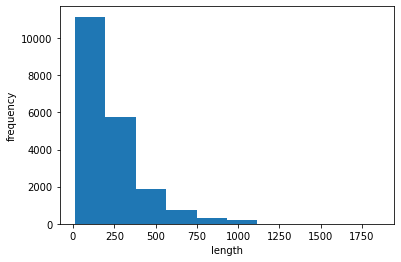

In [ ]:
import matplotlib.pyplot as plt

plt.hist(lengths) # 리뷰 히스토그램 그리기
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

보면 리뷰 데이터가 어떤건 1000글자가 넘는 애도 있다.

이제 얘들을 훈련 시키기 위해, 토큰 수를 통일시켜야 한다.

이 예제에서는 100개의 토큰만을 사용하도록 하자.
- 100개보다 적은 토큰수 의 리뷰는, 0으로 패딩한다.
- 케라스에서는 시퀀스 데이터의 길이를 맞춰주는 pad_sequences() 함수를 제공한다.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)

print(train_seq.shape)

(20000, 100)


100개의 토큰(타임스텝)을 갖는 시퀀스가 총 20000개 들어있는 데이터셋이다.

한번 첫 번째 샘플을 출력해보자.

In [ ]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


패딩이 없는 걸 보니 원본 리뷰는 100 단어보다 많았다는 것인데,

그렇다면 이 시퀀스가 원본 리뷰의 앞부분을 자른 것인지, 뒷부분을 자른 것인지 궁금하다.

원본 리뷰의 마지막 10글자를 확인해보자.

In [ ]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


위 결과를 통해 pad_sequences() 함수는 시퀀스의 앞부분을 자르는 것을 알 수 있다.
- 이는 보통 데이터의 끝부분에 결정적인 정보를 담고 있을 가능성을 고려한 결과이다.
- 만약 뒷부분을 자르고 싶다면, truncating 매개변수의 값을 'post'로 바꿔준다. (default: 'pre')

In [ ]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


이 시퀀스는 패딩이 되어있다.
- 물론 원본 리뷰 앞부분에 패딩이 들어간다.
- 만약 뒷부분에 패딩을 넣고싶다면, padding 매개변수의 값을 'post'로 바꿔준다. (default: 'pre')

이제 검증 세트도 시퀀스의 길이를 100으로 맞춰주자.

In [ ]:
val_seq = pad_sequences(val_input, maxlen=100)

# RNN 만들기

케라스는 여러 종류의 순환층 클래스를 제공하는데, 그 중 가장 간단한 것이 SimpleRNN 클래스이다.

이진분류 문제이므로, 출력층은 1개의 뉴런을 가지고 시그모이드 활성화 함수를 사용한다.

In [ ]:
from tensorflow import keras
import tensorflow as tf

model = keras.Sequential() # 순환(Sequential) 데이터와는 관계 없다.
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

SimpleRNN 클래스의 첫 매개변수는 사용할 뉴런의 개수.
- input_shape: 입력 차원
    - 첫 차원이 100인 것은, 시퀀스의 길이가 100이기 때문
    - 500은 무엇? --> 아래에 설명
- activation: (default: 'tanh') 기본값 그대로 사용
- dropout: 드롭아웃 설정 가능
- return_sequences: 매개변수에서 모든 타임스텝의 은닉 상태를 출력할지 결정 (default: False)


input_shape의 두 번째 차원 500의 의미?
- 단어-정수 매핑 까지는 좋다. 근데, 큰 문제가 있다.
    - 모델은 큰 정수에 대해 큰 활성화 출력을 만들기 때문
    - 정수가 크다고 단어가 중요한 것이 아닌데, 이러면 제대로 학습이 불가
- 정수값에 있는 크기 속성을 없애고, 각 정수를 고유하게 표현하기 위해 원-핫 인코딩을 이용하자.
    - 그러려면 사전의 총 길이(우리가 지정한 500)만큼의 배열이 필요하다.
    - 그래서 시퀀스의 각 토큰마다 500 만큼의 길이를 갖는 차원이 필요한 것.
- 케라스는 원-핫 인코딩을 위한 유틸리티를 제공한다.

In [ ]:
train_oh = keras.utils.to_categorical(train_seq)

print(train_oh.shape)

(20000, 100, 500)


train_seq: (20000, 100)
--> train_oh: (20000, 100, 500)

잘 인코딩 되었는지, 학습 세트의 첫 리뷰의 첫 단어 '10'을 예시로 확인해보자.

In [ ]:
print(train_oh[0][0][:12])
print(np.sum(train_oh[0][0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
1.0


11번째 데이터(10번 데이터)가 1로 켜져있는 것과, 전체 배열의 합이 1인 것을 확인하였다.

다음으로는 검증 세트도 같은 방식으로 원-핫 인코딩을 하자

In [ ]:
val_oh = keras.utils.to_categorical(val_seq)

이제 훈련 세트와 검증 세트가 모두 준비되었으니, 앞서 만든 모델의 구조를 출력해보자.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


순환층의 출력은, 뉴런의 개수와 같은 8개이다.

순환층의 모델 파라미터는 다음과 같이 구성된다.
- $w_x$: (입력되는 특성의 개수) $×$ (뉴런의 개수)
 - $ = 500 × 8 = 4000 $
 - 각 시퀀스의 각 토큰을 입력으로 받을 때, 그 특성이 원-핫 인코딩으로 주어지므로 500
- $w_h$: (뉴런의 개수)$^2 = 8^2 = 64$
- $bias$: (뉴런의 개수)$ = 8$
- --> $4000 + 64 + 8 = 4072$

밀집층의 모델 파라미터는 다음과 같이 구성된다.
- 8 to 1 + bias = 9

# RNN 훈련하기

CNN 신경망과 훈련하는 방법은 모두 같다. (케라스 API의 장점)
- 이 예제에서는 기본 optimizer인 RMSprop의 학습률을 0.001이 아닌 0.0001을 사용하기 위해, 별도의 RMSprop 객체를 만든다.
- 그 다음 에포크 횟수를 100으로 늘리고, 배치 크기는 64로 설정한다.
- 그 밖에 cb나 조기 종료룰 구성하는 코드는 거의 동일

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4) # 이런 표현도 가능
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 17s 50ms/step - loss: 0.6936 - accuracy: 0.5251 - val_loss: 0.6864 - val_accuracy: 0.5488
Epoch 2/100
313/313 [==============================] - 27s 85ms/step - loss: 0.6776 - accuracy: 0.5822 - val_loss: 0.6730 - val_accuracy: 0.5978
Epoch 3/100
313/313 [==============================] - 23s 74ms/step - loss: 0.6614 - accuracy: 0.6257 - val_loss: 0.6570 - val_accuracy: 0.6378
Epoch 4/100
313/313 [==============================] - 22s 70ms/step - loss: 0.6444 - accuracy: 0.6579 - val_loss: 0.6413 - val_accuracy: 0.6648
Epoch 5/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6271 - accuracy: 0.6827 - val_loss: 0.6260 - val_accuracy: 0.6758
Epoch 6/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6103 - accuracy: 0.7033 - val_loss: 0.6089 - val_accuracy: 0.7070
Epoch 7/100
313/313 [==============================] - 13s 40ms/step - loss: 0.5933 - accuracy: 0.7193 - val_loss: 0.5951 - val_ac

이 훈련은 40번째 에포크에서 검증 데이터 78.48% 정확도로 조기 종료되었다.

그럼 이전 장에서처럼 훈련 손실과 검증 손실을 그래프로 그려서 훈련 과정을 살펴보자.

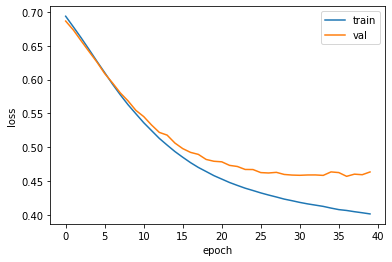

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

성능은 그저 그렇지만, 원-핫 인코딩 방식은 공간 낭비가 너무 심하다.

이 문제를 해결할 만한 더 좋은 단어 표현 방법을 알아보자.

# 단어 임베딩 사용하기

단어 임베딩 (word embedding)
- 각 단어를 고정된 크기의 실수 벡터로 바꾸어준다.
    - 예: 'cat' --> [0.2, 0.1, 1.3, 0.8, 0.2, 0.4, 1.1, 0.9, 0.2, 0.1]
- 단어 임베딩 벡터는 원-핫 인코딩 벡터보다 훨씬 의미 있는 값으로 채워져 있기 때문에 NLP에서 더 좋은 성능을 내는 경우가 많다.
    - 원 핫 인코딩은 사전 규모가 커질수록 달라붙은 차원 크기가 매우 커지지만,
    - 단어 임베딩은 크기 20정도만 붙어도, 단어를 잘 표현할 수 있다.
- keras.layers.Embedding 클래스로 임베딩 기능을 제공한다.
- 이 클래스를 다른 층처럼 모델에 추가하면, 처음엔 모든 벡터가 랜덤하게 초기화되지만 훈련을 통해 좋은 단어 임베딩을 학습한다.
- 입력으로 정수 데이터를 받을 수 있기 때문에, train_oh 대신, train_seq를 사용할 수 있다. --> 메모리 효율에 좋다.

In [ ]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

Embedding 클래스
- 첫째 매개변수: 어휘사전의 크기
- 둘째 매개변수: 임베딩 벡터의 크기 # 원-핫 인코딩(500)보다 훨씬 작은 수
- input_length 매개변수: 입력 시퀀스의 길이

이제 모델의 summary()를 출력해보자

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


단어 임베딩 층의 모델 파라미터
- 단어 사전에 들어있는 500개의 토큰을 각각 크기가 16인 벡터로 변환 $500 \times 16 = 8000$

SimpleRNN 층의 모델 파라미터
- 16개의 입력과 8개의 출력 + 8개 뉴런 간의 은닉 상태 전파 + 8개의 절편
- $16 \times 8 + 8^2 + 8 = 128 + 64 + 8 = 200$

Dense 층의 모델 파라미터
- 8개의 입력과 1개의 출력 + 1개의 절편 --> 9

원-핫 인코딩보다 SimpleRNN에 주입되는 입력의 크기가 크게 줄었지만, 임베딩 벡터는 단어를 잘 표현하는 능력이 있기 때문에 훈련 결과는 나쁘지 않을 것이다.

모델 훈련 과정은 이전과 동일하다.

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 10s 28ms/step - loss: 0.6959 - accuracy: 0.5086 - val_loss: 0.6934 - val_accuracy: 0.5156
Epoch 2/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6903 - accuracy: 0.5367 - val_loss: 0.6910 - val_accuracy: 0.5268
Epoch 3/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6858 - accuracy: 0.5576 - val_loss: 0.6889 - val_accuracy: 0.5400
Epoch 4/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6814 - accuracy: 0.5744 - val_loss: 0.6868 - val_accuracy: 0.5450
Epoch 5/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6767 - accuracy: 0.5898 - val_loss: 0.6845 - val_accuracy: 0.5542
Epoch 6/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6716 - accuracy: 0.6062 - val_loss: 0.6819 - val_accuracy: 0.5628
Epoch 7/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6661 - accuracy: 0.6127 - val_loss: 0.6795 - val_accuracy

이번에는 검증 정확도 77.12% 정도에서 훈련이 끝났다.

원-핫 인코딩과 비슷한 정확도지만, 그래도 훨씬 적은 차원으로 이정도면 나쁘지 않은 것 같다.

마지막으로 훈련 손실과 검증 손실을 그래프로 출력해보자.

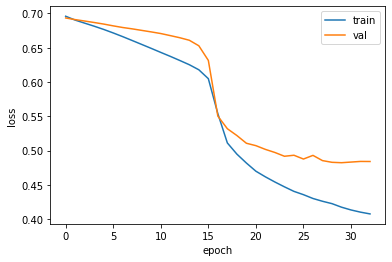

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

이게 뭔 그래프냐????

아무튼 다음 절에서는 더 복잡한 문제에 적용할 수 있는 고급 순환층을 배워보자.